# Dataset overview
The dataset is downloaded from https://www.kaggle.com/crowdflower/twitter-user-gender-classification

The dataset contains the following fields:<br>
unitid: a unique id for user<br>
_golden: whether the user was included in the gold standard for the model; TRUE or FALSE<br>
unitstate: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)<br>
trustedjudgments: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations<br>
lastjudgment_at: date and time of last contributor judgment; blank for gold standard observations<br>
gender: one of male, female, or brand (for non-human profiles)<br>
gender:confidence: a float representing confidence in the provided gender<br>
profile_yn: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it<br>
profile_yn:confidence: confidence in the existence/non-existence of the profile<br>
created: date and time when the profile was created<br>
description: the user's profile description<br>
fav_number: number of tweets the user has favorited<br>
gender_gold: if the profile is golden, what is the gender?<br>
link_color: the link color on the profile, as a hex value<br>
name: the user's name<br>
profileyngold: whether the profile y/n value is golden<br>
profileimage: a link to the profile image<br>
retweet_count: number of times the user has retweeted (or possibly, been retweeted)<br>
sidebar_color: color of the profile sidebar, as a hex value<br>
text: text of a random one of the user's tweets<br>
tweet_coord: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"<br>
tweet_count: number of tweets that the user has posted<br>
tweet_created: when the random tweet (in the text column) was created<br>
tweet_id: the tweet id of the random tweet<br>
tweet_location: location of the tweet; seems to not be particularly normalized<br>
user_timezone: the timezone of the user<br>

In [978]:
import pandas as pd
import numpy as np
from collections import Counter
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
import warnings
from sklearn.model_selection import GridSearchCV
import datetime as dt
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import os
from os import path
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from statistics import mean
warnings.filterwarnings('ignore')
from gensim.models.doc2vec import TaggedDocument

In [979]:
dataset=pd.read_csv('gender-classifier-DFE-791531.csv', encoding = "ISO-8859-1")

# Data Cleaning and Exploration

In [980]:
dataset.head()

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  815719226    False   finalized                   3    10/26/15 23:24   
1  815719227    False   finalized                   3    10/26/15 23:30   
2  815719228    False   finalized                   3    10/26/15 23:33   
3  815719229    False   finalized                   3    10/26/15 23:10   
4  815719230    False   finalized                   3     10/27/15 1:15   

   gender  gender:confidence profile_yn  profile_yn:confidence  \
0    male             1.0000        yes                    1.0   
1    male             1.0000        yes                    1.0   
2    male             0.6625        yes                    1.0   
3    male             1.0000        yes                    1.0   
4  female             1.0000        yes                    1.0   

          created  ...                                       profileimage  \
0    12/5/13 1:48  ...  https://pbs.twimg.com/profile_images/414342229...   
1   10/1/12 13:51  ...  https://pbs.twimg.com/profile_images/539604221...   
2  11/28/14 11:30  ...  https://pbs.twimg.com/profile_images/657330418...   
3   6/11/09 22:39  ...  https://pbs.twimg.com/profile_images/259703936...   
4   4/16/14 13:23  ...  https://pbs.twimg.com/profile_images/564094871...   

   retweet_count sidebar_color  \
0              0        FFFFFF   
1              0        C0DEED   
2              1        C0DEED   
3              0        C0DEED   
4              0             0   

                                                text tweet_coord tweet_count  \
0  Robbie E Responds To Critics After Win Against...         NaN      110964   
1  ÛÏIt felt like they were my friends and I was...         NaN        7471   
2  i absolutely adore when louis starts the songs...         NaN        5617   
3  Hi @JordanSpieth - Looking at the url - do you...         NaN        1693   
4  Watching Neighbours on Sky+ catching up with t...         NaN       31462   

    tweet_created      tweet_id   tweet_location               user_timezone  
0  10/26/15 12:40  6.587300e+17  main; @Kan1shk3                     Chennai  
1  10/26/15 12:40  6.587300e+17              NaN  Eastern Time (US & Canada)  
2  10/26/15 12:40  6.587300e+17           clcncl                    Belgrade  
3  10/26/15 12:40  6.587300e+17    Palo Alto, CA  Pacific Time (US & Canada)  
4  10/26/15 12:40  6.587300e+17              NaN                         NaN  

[5 rows x 26 columns]

In [981]:
dataset.shape

(20050, 26)

In [982]:
dataset.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [983]:
# After checked the variables, I decide to drop some columns that I think are irrelevant to my analysis or with too many n/a values.
dataset_clean=dataset.drop(columns=['_unit_id','_golden','_unit_state','_trusted_judgments','_last_judgment_at','profile_yn', 'profile_yn:confidence', 'created', 'gender_gold', 'name','profile_yn_gold','profileimage','tweet_coord','tweet_created','tweet_id','tweet_location','user_timezone'])

In [984]:
# Check gender distribution
# I don't want to drop unknown since it has large data, and it could becuase people find it's difficult to find their identity
dataset_clean.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [985]:
dataset_clean.isnull().sum()

gender                 97
gender:confidence      26
description          3744
fav_number              0
link_color              0
retweet_count           0
sidebar_color           0
text                    0
tweet_count             0
dtype: int64

In [986]:
dataset_clean.nunique()

gender                   4
gender:confidence      923
description          15140
fav_number            6784
link_color            3001
retweet_count           22
sidebar_color          561
text                 18412
tweet_count          14280
dtype: int64

In [987]:
# since the null value amount is relatively small for gender and gender:confidence columns, so I decide to drop them
dataset_clean=dataset_clean.dropna(subset=['gender', 'gender:confidence'])

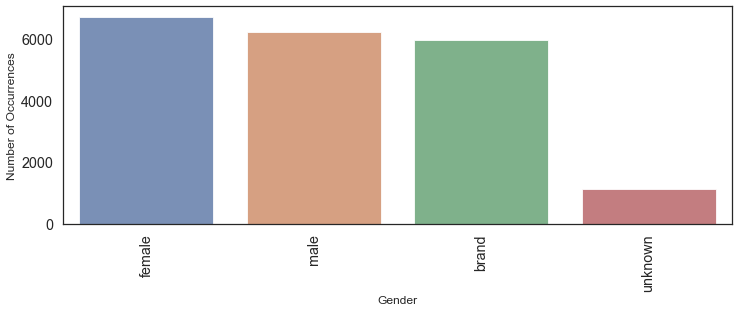

In [988]:
# visualize gender column
cnt_pro = dataset_clean['gender'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation=90)
plt.show();

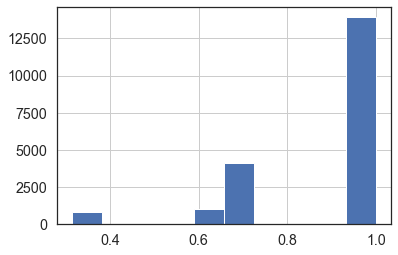

In [989]:
dataset_clean['gender:confidence'].hist()

0    3326
1     393
2     253
3     193
5     162
Name: fav_number, dtype: int64

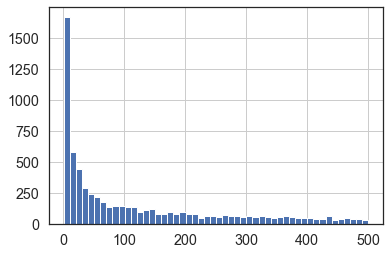

In [990]:
dataset_clean.fav_number.hist(range=[1,500],bins=50)
dataset_clean.fav_number.value_counts().head()

In [991]:
dataset_clean.head()

gender  gender:confidence  \
0    male             1.0000   
1    male             1.0000   
2    male             0.6625   
3    male             1.0000   
4  female             1.0000   

                                         description  fav_number link_color  \
0                              i sing my own rhythm.           0     08C2C2   
1  I'm the author of novels filled with family dr...          68     0084B4   
2                louis whining and squealing and all        7696     ABB8C2   
3  Mobile guy.  49ers, Shazam, Google, Kleiner Pe...         202     0084B4   
4  Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...       37318     3B94D9   

   retweet_count sidebar_color  \
0              0        FFFFFF   
1              0        C0DEED   
2              1        C0DEED   
3              0        C0DEED   
4              0             0   

                                                text  tweet_count  
0  Robbie E Responds To Critics After Win Against...       110964  
1  ÛÏIt felt like they were my friends and I was...         7471  
2  i absolutely adore when louis starts the songs...         5617  
3  Hi @JordanSpieth - Looking at the url - do you...         1693  
4  Watching Neighbours on Sky+ catching up with t...        31462

In [992]:
# handle the text data, since there are many n/a value in description column, but it's a important feature, so I will put special text for the n/a values
dataset_clean['description'].fillna('no_description',inplace=True)
dataset_clean.isnull().sum()

gender               0
gender:confidence    0
description          0
fav_number           0
link_color           0
retweet_count        0
sidebar_color        0
text                 0
tweet_count          0
dtype: int64

In [993]:
dataset_clean['text'].apply(lambda x: len(x.split(' '))).sum()

309434

In [994]:
dataset_clean['description'].apply(lambda x: len(x.split(' '))).sum()

221999

In [995]:
tweet_length = np.array(list(map(len, dataset_clean.text.str.split(' '))))
description_length = np.array(list(map(len, dataset_clean.description.str.split(' '))))

    
print("The average number of words in a tweet is: {}.".format(np.mean(tweet_length)))
print("The minimum number of words in a tweet is: {}.".format(min(tweet_length)))
print("The maximum number of words in a tweet is: {}.".format(max(tweet_length)))

print("The average number of words in a description is: {}.".format(np.mean(description_length)))
print("The minimum number of words in a description is: {}.".format(min(description_length)))
print("The maximum number of words in a description is: {}.".format(max(description_length)))

The average number of words in a tweet is: 15.508144138726006.
The minimum number of words in a tweet is: 1.
The maximum number of words in a tweet is: 45.
The average number of words in a description is: 11.126096326366962.
The minimum number of words in a description is: 1.
The maximum number of words in a description is: 129.


In [996]:
dataset_clean["text_length"]=dataset_clean["text"].apply(lambda x: len(x.split(' ')))
dataset_clean["description_length"]=dataset_clean["description"].apply(lambda x: len(x.split(' ')))

In [997]:
print("There are {} tweets with over 15 words.".format(sum(dataset_clean["text_length"] > 15)))
print("There are {} description with over 11 words.".format(sum(dataset_clean["description_length"] > 11)))

There are 9875 tweets with over 15 words.
There are 8809 description with over 11 words.


In [1055]:
dataset_clean

gender  gender:confidence  \
0        male             1.0000   
1        male             1.0000   
2        male             0.6625   
3        male             1.0000   
4      female             1.0000   
...       ...                ...   
20045  female             1.0000   
20046    male             1.0000   
20047    male             1.0000   
20048  female             0.8489   
20049  female             1.0000   

                                             description  fav_number  \
0                                  i sing my own rhythm.           0   
1      i'm the author of novels filled with family dr...          68   
2                    louis whining and squealing and all        7696   
3      mobile guy.  49ers, shazam, google, kleiner pe...         202   
4      ricky wilson the best frontman/kaiser chiefs t...       37318   
...                                                  ...         ...   
20045                                               (rp)         302   
20046  whatever you like, it's not a problem at all. ...        2513   
20047  #teambarcelona ..you look lost so you should f...          50   
20048  anti-statist; i homeschool my kids. aspiring t...       70804   
20049                     teamwork makes the dream work.        3348   

       link_color  retweet_count  sidebar_color  \
0             248              0            558   
1              77              0            365   
2            2002              1            365   
3              77              0            365   
4            1014              0              0   
...           ...            ...            ...   
20045          77              0            365   
20046        2318              0              0   
20047          77              0            365   
20048        1793              0              0   
20049          77              0            365   

                                                    text  tweet_count  \
0      robbie e responds to critics after win against...       110964   
1      ûïit felt like they were my friends and i was...         7471   
2      i absolutely adore when louis starts the songs...         5617   
3      hi @jordanspieth - looking at the url - do you...         1693   
4      watching neighbours on sky+ catching up with t...        31462   
...                                                  ...          ...   
20045  @lookupondeath ...fine, and i'll drink tea too...          783   
20046  greg hardy you a good player and all but don't...        13523   
20047  you can miss people and still never want to se...        26419   
20048  @bitemyapp i had noticed your tendency to pee ...        56073   
20049  i think for my apush creative project i'm goin...         2922   

       text_length  description_length  \
0               14                   5   
1               19                  11   
2               16                   6   
3               23                  24   
4               12                  27   
...            ...                 ...   
20045           10                   1   
20046           21                  16   
20047           12                  18   
20048           19                  18   
20049           21                   5   

                                              text_token  \
0      [robbie, e, responds, critics, win, eddie, edw...   
1          [felt, like, friends, living, story, retired]   
2      [absolutely, adore, louis, starts, songs, hits...   
3      [hi, jordanspieth, looking, url, use, ifttt, t...   
4              [watching, neighbours, catching, neighbs]   
...                                                  ...   
20045            [lookupondeath, fine, drink, tea, love]   
20046  [greg, hardy, good, player, get, face, dez, br...   
20047            [miss, people, still, never, want, see]   
20048  [bitemyapp, noticed, tendency, pee, carpet, wa...   
20049  [think, apush, creative, project, going, bring.

# Q1: What are the words in tweets that strongly distinguish  male or female gender?

In [1045]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>|<url>', text)
    text = re.sub(r'ù*|÷*|ä*|ô*|î*|è*|â*|x89û_*|ã*|_*|x8*',r'', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
dataset_clean['text'] = dataset_clean['text'].apply(cleanText)
dataset_clean['description'] = dataset_clean['description'].apply(cleanText)

In [1046]:
nltk.download('stopwords')
customize_words=['.',',','the','-','’','#','@','!']
S = set(stopwords.words('english'))
new_list = S.union(customize_words)
tokens_stop_removed = []
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if not word.lower() in new_list:
                if word.isalpha():
                
                    tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package stopwords to /Users/aaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1047]:
nltk.download('punkt')
dataset_clean['text_token']=dataset_clean.text.apply(tokenize_text)
dataset_clean['description_token']=dataset_clean.description.apply(tokenize_text)

[nltk_data] Downloading package punkt to /Users/aaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1048]:
dataset_clean

gender  gender:confidence  \
0        male             1.0000   
1        male             1.0000   
2        male             0.6625   
3        male             1.0000   
4      female             1.0000   
...       ...                ...   
20045  female             1.0000   
20046    male             1.0000   
20047    male             1.0000   
20048  female             0.8489   
20049  female             1.0000   

                                             description  fav_number  \
0                                  i sing my own rhythm.           0   
1      i'm the author of novels filled with family dr...          68   
2                    louis whining and squealing and all        7696   
3      mobile guy.  49ers, shazam, google, kleiner pe...         202   
4      ricky wilson the best frontman/kaiser chiefs t...       37318   
...                                                  ...         ...   
20045                                               (rp)         302   
20046  whatever you like, it's not a problem at all. ...        2513   
20047  #teambarcelona ..you look lost so you should f...          50   
20048  anti-statist; i homeschool my kids. aspiring t...       70804   
20049                     teamwork makes the dream work.        3348   

       link_color  retweet_count  sidebar_color  \
0             248              0            558   
1              77              0            365   
2            2002              1            365   
3              77              0            365   
4            1014              0              0   
...           ...            ...            ...   
20045          77              0            365   
20046        2318              0              0   
20047          77              0            365   
20048        1793              0              0   
20049          77              0            365   

                                                    text  tweet_count  \
0      robbie e responds to critics after win against...       110964   
1      ûïit felt like they were my friends and i was...         7471   
2      i absolutely adore when louis starts the songs...         5617   
3      hi @jordanspieth - looking at the url - do you...         1693   
4      watching neighbours on sky+ catching up with t...        31462   
...                                                  ...          ...   
20045  @lookupondeath ...fine, and i'll drink tea too...          783   
20046  greg hardy you a good player and all but don't...        13523   
20047  you can miss people and still never want to se...        26419   
20048  @bitemyapp i had noticed your tendency to pee ...        56073   
20049  i think for my apush creative project i'm goin...         2922   

       text_length  description_length  \
0               14                   5   
1               19                  11   
2               16                   6   
3               23                  24   
4               12                  27   
...            ...                 ...   
20045           10                   1   
20046           21                  16   
20047           12                  18   
20048           19                  18   
20049           21                   5   

                                              text_token  \
0      [robbie, e, responds, critics, win, eddie, edw...   
1          [felt, like, friends, living, story, retired]   
2      [absolutely, adore, louis, starts, songs, hits...   
3      [hi, jordanspieth, looking, url, use, ifttt, t...   
4              [watching, neighbours, catching, neighbs]   
...                                                  ...   
20045            [lookupondeath, fine, drink, tea, love]   
20046  [greg, hardy, good, player, get, face, dez, br...   
20047            [miss, people, still, never, want, see]   
20048  [bitemyapp, noticed, tendency, pee, carpet, wa...   
20049  [think, apush, creative, project, going, bring.

In [1049]:
female = dataset_clean[dataset_clean['gender']=='female'].text_token.sum()
male = dataset_clean[dataset_clean['gender']=='male'].text_token.sum()

In [1050]:
female_str=' '.join(female)
male_str=' '.join(male)

In [1051]:
#reference link: https://www.datacamp.com/community/tutorials/wordcloud-python
mask_female = np.array(Image.open("female.jpeg"))
mask_male = np.array(Image.open("male.jpg"))

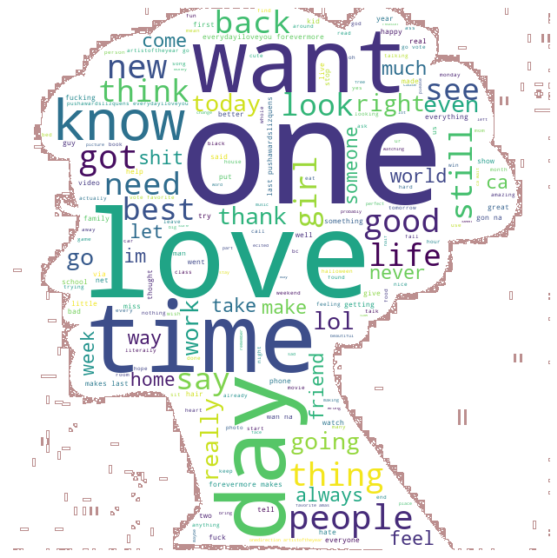

In [1052]:
wc1 = WordCloud(background_color="white",  mask=mask_female,
                contour_width=1, contour_color='rosybrown')
# Generate a wordcloud
wc1.generate(female_str)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

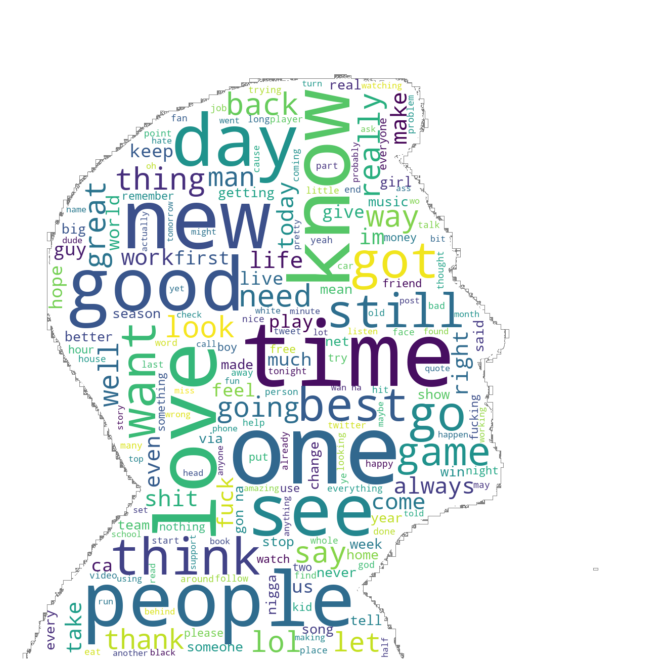

In [1053]:

wc2 = WordCloud(background_color="white",  mask=mask_male,
                contour_width=1, contour_color='gray')

# Generate a wordcloud
wc2.generate(male_str)

# show
plt.figure(figsize=[22,12])
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1008]:
f_common=Counter(female).most_common(100)
m_common=Counter(male).most_common(100)

In [1153]:
def remove_overlap_common_words(m,f):
    f = dict(f)
    m = dict(m)
    f_ = []
    m_ = []
    
    for k in f:
        if k not in m:
            f_.append((k,f[k]))
    for k in m:
        if k not in f:
            m_.append((k,m[k]))
            
    f = dict(f_)
    m = dict(m_)
    
    wordcloud_f = WordCloud(width=1600,height=900, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(f)
    wordcloud_m = WordCloud(width=1600,height=900, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(m)
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.imshow(wordcloud_f, interpolation='bilinear')
    ax2.imshow(wordcloud_m, interpolation='bilinear')
    fig = plt.figure()
    ax1.set_xlabel('female')
    ax2.set_xlabel('male')
    plt.show()
    return print(f'Most common word of women: {f_}, \n \nMost common word of man: {m_}')

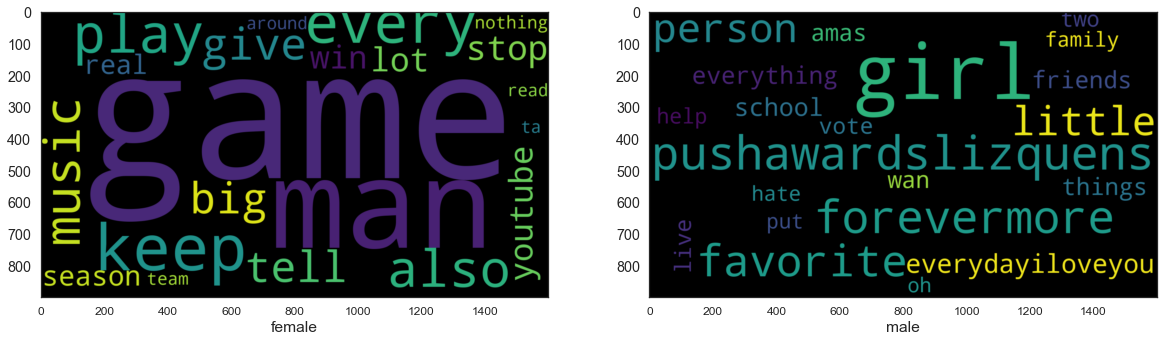

<Figure size 432x288 with 0 Axes>

Most common word of women: [('game', 113), ('man', 96), ('keep', 76), ('every', 72), ('play', 68), ('also', 68), ('music', 66), ('give', 66), ('big', 64), ('tell', 64), ('stop', 64), ('lot', 61), ('youtube', 60), ('win', 59), ('season', 59), ('real', 57), ('nothing', 56), ('team', 56), ('ta', 55), ('around', 55), ('read', 55)], 
 
Most common word of man: [('girl', 105), ('pushawardslizquens', 93), ('forevermore', 92), ('favorite', 88), ('person', 81), ('little', 81), ('everydayiloveyou', 81), ('school', 77), ('everything', 76), ('friends', 75), ('things', 75), ('amas', 74), ('wan', 74), ('vote', 71), ('live', 71), ('two', 69), ('help', 67), ('put', 65), ('family', 65), ('hate', 65), ('oh', 64)]


In [1154]:
remove_overlap_common_words(f_common,m_common)

# Q2 What are the important features to predict gender label?

In [1011]:
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
dataset_clean

gender  gender:confidence  \
0        male             1.0000   
1        male             1.0000   
2        male             0.6625   
3        male             1.0000   
4      female             1.0000   
...       ...                ...   
20045  female             1.0000   
20046    male             1.0000   
20047    male             1.0000   
20048  female             0.8489   
20049  female             1.0000   

                                             description  fav_number  \
0                                  i sing my own rhythm.           0   
1      i'm the author of novels filled with family dr...          68   
2                    louis whining and squealing and all        7696   
3      mobile guy.  49ers, shazam, google, kleiner pe...         202   
4      ricky wilson the best frontman/kaiser chiefs t...       37318   
...                                                  ...         ...   
20045                                               (rp)         302   
20046  whatever you like, it's not a problem at all. ...        2513   
20047  #teambarcelona ..you look lost so you should f...          50   
20048  anti-statist; i homeschool my kids. aspiring t...       70804   
20049                     teamwork makes the dream work.        3348   

      link_color  retweet_count sidebar_color  \
0         08C2C2              0        FFFFFF   
1         0084B4              0        C0DEED   
2         ABB8C2              1        C0DEED   
3         0084B4              0        C0DEED   
4         3B94D9              0             0   
...          ...            ...           ...   
20045     0084B4              0        C0DEED   
20046     CFB929              0             0   
20047     0084B4              0        C0DEED   
20048     9266CC              0             0   
20049     0084B4              0        C0DEED   

                                                    text  tweet_count  \
0      robbie e responds to critics after win against...       110964   
1      ûïit felt like they were my friends and i was...         7471   
2      i absolutely adore when louis starts the songs...         5617   
3      hi @jordanspieth - looking at the url - do you...         1693   
4      watching neighbours on sky+ catching up with t...        31462   
...                                                  ...          ...   
20045  @lookupondeath ...fine, and i'll drink tea too...          783   
20046  greg hardy you a good player and all but don't...        13523   
20047  you can miss people and still never want to se...        26419   
20048  @bitemyapp i had noticed your tendency to pee ...        56073   
20049  i think for my apush creative project i'm goin...         2922   

       text_length  description_length  \
0               14                   5   
1               19                  11   
2               16                   6   
3               23                  24   
4               12                  27   
...            ...                 ...   
20045           10                   1   
20046           21                  16   
20047           12                  18   
20048           19                  18   
20049           21                   5   

                                              text_token  \
0      [robbie, e, responds, critics, win, eddie, edw...   
1      [felt, like, friends, living, story, url, url,...   
2      [absolutely, adore, louis, starts, songs, hits...   
3      [hi, jordanspieth, looking, url, use, ifttt, t...   
4              [watching, neighbours, catching, neighbs]   
...                                                  ...   
20045            [lookupondeath, fine, drink, tea, love]   
20046  [greg, hardy, good, player, get, face, dez, br...   
20047            [miss, people, still, never, want, see]   
20048  [bitemyapp, noticed, tendency, pee, carpet, wa...   
20049  [think, apush, creative, project, going, bring...   

                 

In [1012]:
dataset_clean['link_color'] = dataset_clean['link_color'].astype('category')
dataset_clean['sidebar_color'] = dataset_clean['sidebar_color'].astype('category')
cat_columns = dataset_clean.select_dtypes(['category']).columns
dataset_clean[cat_columns] = dataset_clean[cat_columns].apply(lambda x: x.cat.codes)

In [1013]:
dataset_clean

gender  gender:confidence  \
0        male             1.0000   
1        male             1.0000   
2        male             0.6625   
3        male             1.0000   
4      female             1.0000   
...       ...                ...   
20045  female             1.0000   
20046    male             1.0000   
20047    male             1.0000   
20048  female             0.8489   
20049  female             1.0000   

                                             description  fav_number  \
0                                  i sing my own rhythm.           0   
1      i'm the author of novels filled with family dr...          68   
2                    louis whining and squealing and all        7696   
3      mobile guy.  49ers, shazam, google, kleiner pe...         202   
4      ricky wilson the best frontman/kaiser chiefs t...       37318   
...                                                  ...         ...   
20045                                               (rp)         302   
20046  whatever you like, it's not a problem at all. ...        2513   
20047  #teambarcelona ..you look lost so you should f...          50   
20048  anti-statist; i homeschool my kids. aspiring t...       70804   
20049                     teamwork makes the dream work.        3348   

       link_color  retweet_count  sidebar_color  \
0             248              0            558   
1              77              0            365   
2            2002              1            365   
3              77              0            365   
4            1014              0              0   
...           ...            ...            ...   
20045          77              0            365   
20046        2318              0              0   
20047          77              0            365   
20048        1793              0              0   
20049          77              0            365   

                                                    text  tweet_count  \
0      robbie e responds to critics after win against...       110964   
1      ûïit felt like they were my friends and i was...         7471   
2      i absolutely adore when louis starts the songs...         5617   
3      hi @jordanspieth - looking at the url - do you...         1693   
4      watching neighbours on sky+ catching up with t...        31462   
...                                                  ...          ...   
20045  @lookupondeath ...fine, and i'll drink tea too...          783   
20046  greg hardy you a good player and all but don't...        13523   
20047  you can miss people and still never want to se...        26419   
20048  @bitemyapp i had noticed your tendency to pee ...        56073   
20049  i think for my apush creative project i'm goin...         2922   

       text_length  description_length  \
0               14                   5   
1               19                  11   
2               16                   6   
3               23                  24   
4               12                  27   
...            ...                 ...   
20045           10                   1   
20046           21                  16   
20047           12                  18   
20048           19                  18   
20049           21                   5   

                                              text_token  \
0      [robbie, e, responds, critics, win, eddie, edw...   
1      [felt, like, friends, living, story, url, url,...   
2      [absolutely, adore, louis, starts, songs, hits...   
3      [hi, jordanspieth, looking, url, use, ifttt, t...   
4              [watching, neighbours, catching, neighbs]   
...                                                  ...   
20045            [lookupondeath, fine, drink, tea, love]   
20046  [greg, hardy, good, player, get, face, dez, br...   
20047            [miss, people, still, never, want, see]   
20048  [bitemyapp, noticed, tendency, pee, carpet, wa...   
20049  [think, apush, creative, project, going, bring.

In [1014]:
cores = multiprocessing.cpu_count()

In [1015]:
train, test = train_test_split(dataset_clean, test_size=0.3, random_state=42)

In [1016]:
text_train_tagged = train.apply(lambda r: TaggedDocument(words=r.text_token, tags=r.gender), axis=1)
text_test_tagged = test.apply(lambda r: TaggedDocument(words=r.text_token, tags=r.gender), axis=1)
description_train_tagged = train.apply(lambda r: TaggedDocument(words=r.description_token, tags=r.gender), axis=1)
description_test_tagged = test.apply(lambda r: TaggedDocument(words=r.description_token, tags=r.gender), axis=1)

In [1017]:
text_model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
text_model_dbow.build_vocab([x for x in tqdm(text_train_tagged.values)])

100%|██████████| 13967/13967 [00:00<00:00, 306744.95it/s]


In [1018]:
description_model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
description_model_dbow.build_vocab([x for x in tqdm(description_train_tagged.values)])

100%|██████████| 13967/13967 [00:00<00:00, 357496.29it/s]


In [1019]:
%%time
for epoch in range(30):
    text_model_dbow.train(utils.shuffle([x for x in tqdm(text_train_tagged.values)]), total_examples=len(text_train_tagged.values), epochs=1)
    text_model_dbow.alpha -= 0.0002
    text_model_dbow.min_alpha = text_model_dbow.alpha

100%|██████████| 13967/13967 [00:00<00:00, 1386290.03it/s]


CPU times: user 1min 30s, sys: 8.66 s, total: 1min 39s
Wall time: 1min 5s


In [1020]:
%%time
for epoch in range(30):
    description_model_dbow.train(utils.shuffle([x for x in tqdm(description_train_tagged.values)]), total_examples=len(description_train_tagged.values), epochs=1)
    description_model_dbow.alpha -= 0.0002
    description_model_dbow.min_alpha = description_model_dbow.alpha

100%|██████████| 13967/13967 [00:00<00:00, 1538429.16it/s]


CPU times: user 1min 14s, sys: 8.93 s, total: 1min 23s
Wall time: 50.1 s


In [1021]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [1022]:
text_y_train, text_X_train = vec_for_learning(text_model_dbow, text_train_tagged)
text_y_test, text_X_test = vec_for_learning(text_model_dbow, text_test_tagged)
description_y_train, description_X_train = vec_for_learning(description_model_dbow, description_train_tagged)
description_y_test, description_X_test = vec_for_learning(description_model_dbow, description_test_tagged)

In [1023]:
len(text_X_test[0])

300

In [1024]:
drop_cols = [c for c in train.columns if c not in dataset_clean.columns]
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [1025]:
added_text = pd.DataFrame(data=text_X_train, columns=['embedding_text_'+str(i) for i in range(len(text_X_train[0]))])
added_description = pd.DataFrame(data=description_X_train, columns=['embedding_description_'+str(i) for i in range(len(description_X_train[0]))])
train.index = range(len(train.index))
for c in added_text.columns:
    train[c] = added_text[c]
for c in added_description.columns:
    train[c] = added_description[c]

train.dropna()

gender  gender:confidence  \
0      unknown             0.3475   
1         male             0.6699   
2        brand             1.0000   
3        brand             1.0000   
4        brand             0.6674   
...        ...                ...   
13962     male             1.0000   
13963     male             1.0000   
13964   female             1.0000   
13965     male             1.0000   
13966    brand             1.0000   

                                             description  fav_number  \
0      gamer, youtuber, king (not) and book lover. th...          44   
1      smol unsuccessful version of dan howell ü@...       19592   
2      the map game is a free geography quiz based on...           1   
3                                   soul food restaurant         159   
4                                          nodescription           0   
...                                                  ...         ...   
13962              i'm doing this at home and you can't.           5   
13963  follow this step-by-step lessons and become a ...           4   
13964  born in the wrong generation. resourceful, art...       40054   
13965            a atheist, a sports fan and a metalhead         179   
13966  innovative, eciting, fun and progressive rugby...          40   

       link_color  retweet_count  sidebar_color  \
0              77              0            365   
1               0              0              0   
2             994              0            470   
3            2002              0              0   
4              77              0            365   
...           ...            ...            ...   
13962        1268              0              0   
13963          77              0            365   
13964        2882              0            219   
13965          77              0            365   
13966        1867              0            558   

                                                    text  tweet_count  \
0      @universalorl #askuniversal how would you rate...          416   
1      kiss me on the dick and set me free but plz do...        14580   
2      where is crawley on the map? play the game at ...      2372591   
3      #potliquor : a southern tip to save nutritious...           82   
4      get weather updates from the weather channel. ...        36504   
...                                                  ...          ...   
13962  we do not escape into philosophy, psychology, ...         9825   
13963  build #businessonline, no products to make, st...         1584   
13964  @rona65 @radgentleman the world would be a bet...        39806   
13965  @officialtaz do we still have blading in the w...          108   
13966  all systems go @fairfordrfc on 28/29th this we...          427   

       text_length  ...  embedding_description_290 embedding_description_291  \
0               14  ...                   0.000973                  0.309356   
1               14  ...                   0.036550                 -0.032121   
2               12  ...                  -0.349521                  0.119158   
3               18  ...                   0.011658                  0.017178   
4                8  ...                  -0.038828                  0.037803   
...            ...  ...                        ...                       ...   
13962           22  ...                  -0.023444                  0.012553   
13963           13  ...                  -0.196676                  0.123825   
13964           19  ...                   0.350141                 -0.008835   
13965           11  ...                  -0.116324                 -0.007394   
13966           21  ...                   0.027368                  0.000923   

      embedding_description_292  embedding_description_293  \
0                      0.018388                  -0.168422   
1                     -0.132678                  -0.001762   
2                      0.078194                   0.044672   

In [1026]:
added_text = pd.DataFrame(data=text_X_test, columns=['embedding_text_'+str(i) for i in range(len(text_X_test[0]))])
added_description = pd.DataFrame(data=description_X_test, columns=['embedding_description_'+str(i) for i in range(len(description_X_test[0]))])
test.index = range(len(test.index))
for c in added_text.columns:
    test[c] = added_text[c]
for c in added_description.columns:
    test[c] = added_description[c]

test.head()

gender  gender:confidence  \
0    brand             0.6798   
1     male             1.0000   
2   female             1.0000   
3  unknown             1.0000   
4     male             1.0000   

                                         description  fav_number  link_color  \
0                                      nodescription           0          77   
1                                      nodescription        5013          77   
2  sonrìe, haz saber a los demìás que hoy eres ma...         869         364   
3                                      nodescription          19          77   
4                                      nodescription         610          77   

   retweet_count  sidebar_color  \
0              0            365   
1              0            365   
2              0            558   
3              0            365   
4              0            365   

                                                text  tweet_count  \
0  get weather updates from the weather channel. ...        40212   
1                   make her smile and she hooked ùò         4285   
2  "first you wanna go left and you want to turn ...         4766   
3  i guess all these super conservative media and...        11606   
4  they should of never gave me the power to have...         4101   

   text_length  ...  embedding_description_290 embedding_description_291  \
0            8  ...                  -0.051202                  0.017984   
1            7  ...                  -0.042739                  0.020780   
2           11  ...                   0.018721                  0.227994   
3           20  ...                  -0.040474                  0.032451   
4           15  ...                  -0.024021                  0.017212   

  embedding_description_292  embedding_description_293  \
0                  0.010187                   0.021576   
1                  0.011288                   0.014466   
2                 -0.088065                  -0.005335   
3                  0.024071                   0.008096   
4                  0.008301                   0.000150   

   embedding_description_294  embedding_description_295  \
0                  -0.048242                   0.004688   
1                  -0.024254                   0.007915   
2                   0.105848                   0.045161   
3                  -0.037400                   0.006843   
4                  -0.024581                  -0.010853   

   embedding_description_296  embedding_description_297  \
0                  -0.004862                  -0.009694   
1                  -0.003235                  -0.005306   
2                   0.090908                   0.394309   
3                   0.004990                   0.008321   
4                   0.014229                   0.006334   

   embedding_description_298  embedding_description_299  
0                   0.007433                  -0.106293  
1                   0.023427                  -0.071635  
2                   0.051347                  -0.230378  
3                   0.026001                  -0.108348  
4                   0.010340                  -0.086760  

[5 rows x 613 columns]

In [1027]:
X_train = train.loc[:, train.columns != 'gender']
X_test = test.loc[:, test.columns != 'gender']
y_train = train.loc[:, train.columns == 'gender']
y_test = test.loc[:, test.columns == 'gender']

In [1028]:
X_train.head()

gender:confidence                                        description  \
0             0.3475  gamer, youtuber, king (not) and book lover. th...   
1             0.6699  smol unsuccessful version of dan howell ü@...   
2             1.0000  the map game is a free geography quiz based on...   
3             1.0000                               soul food restaurant   
4             0.6674                                      nodescription   

   fav_number  link_color  retweet_count  sidebar_color  \
0          44          77              0            365   
1       19592           0              0              0   
2           1         994              0            470   
3         159        2002              0              0   
4           0          77              0            365   

                                                text  tweet_count  \
0  @universalorl #askuniversal how would you rate...          416   
1  kiss me on the dick and set me free but plz do...        14580   
2  where is crawley on the map? play the game at ...      2372591   
3  #potliquor : a southern tip to save nutritious...           82   
4  get weather updates from the weather channel. ...        36504   

   text_length  description_length  ... embedding_description_290  \
0           14                  23  ...                  0.000973   
1           14                  19  ...                  0.036550   
2           12                  26  ...                 -0.349521   
3           18                   3  ...                  0.011658   
4            8                   1  ...                 -0.038828   

  embedding_description_291  embedding_description_292  \
0                  0.309356                   0.018388   
1                 -0.032121                  -0.132678   
2                  0.119158                   0.078194   
3                  0.017178                   0.054085   
4                  0.037803                   0.009906   

   embedding_description_293  embedding_description_294  \
0                  -0.168422                  -0.107036   
1                  -0.001762                  -0.020274   
2                   0.044672                  -0.130194   
3                   0.024500                  -0.059696   
4                   0.018067                  -0.031172   

   embedding_description_295  embedding_description_296  \
0                   0.202526                   0.059256   
1                   0.155388                   0.113209   
2                  -0.064297                  -0.141719   
3                  -0.041900                   0.100863   
4                   0.014808                   0.009684   

   embedding_description_297  embedding_description_298  \
0                   0.304882                  -0.108191   
1                   0.101214                  -0.179556   
2                  -0.111813                   0.292369   
3                  -0.001774                  -0.044452   
4                   0.017526                   0.035838   

   embedding_description_299  
0                   0.106264  
1                   0.010038  
2                  -0.258038  
3                  -0.167606  
4                  -0.091598  

[5 rows x 612 columns]

In [1029]:
X_train=X_train.drop(columns=['text','description','text_token','description_token'])
X_test=X_test.drop(columns=['text','description','text_token','description_token'])

In [1030]:
X_test.head()

gender:confidence  fav_number  link_color  retweet_count  sidebar_color  \
0             0.6798           0          77              0            365   
1             1.0000        5013          77              0            365   
2             1.0000         869         364              0            558   
3             1.0000          19          77              0            365   
4             1.0000         610          77              0            365   

   tweet_count  text_length  description_length  embedding_text_0  \
0        40212            8                   1         -0.002571   
1         4285            7                   1          0.044706   
2         4766           11                  18          0.059021   
3        11606           20                   1          0.157011   
4         4101           15                   1          0.089615   

   embedding_text_1  ...  embedding_description_290  \
0          0.189421  ...                  -0.051202   
1         -0.065468  ...                  -0.042739   
2         -0.153845  ...                   0.018721   
3          0.044509  ...                  -0.040474   
4          0.003880  ...                  -0.024021   

   embedding_description_291  embedding_description_292  \
0                   0.017984                   0.010187   
1                   0.020780                   0.011288   
2                   0.227994                  -0.088065   
3                   0.032451                   0.024071   
4                   0.017212                   0.008301   

   embedding_description_293  embedding_description_294  \
0                   0.021576                  -0.048242   
1                   0.014466                  -0.024254   
2                  -0.005335                   0.105848   
3                   0.008096                  -0.037400   
4                   0.000150                  -0.024581   

   embedding_description_295  embedding_description_296  \
0                   0.004688                  -0.004862   
1                   0.007915                  -0.003235   
2                   0.045161                   0.090908   
3                   0.006843                   0.004990   
4                  -0.010853                   0.014229   

   embedding_description_297  embedding_description_298  \
0                  -0.009694                   0.007433   
1                  -0.005306                   0.023427   
2                   0.394309                   0.051347   
3                   0.008321                   0.026001   
4                   0.006334                   0.010340   

   embedding_description_299  
0                  -0.106293  
1                  -0.071635  
2                  -0.230378  
3                  -0.108348  
4                  -0.086760  

[5 rows x 608 columns]

In [1031]:
tweet_rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
tweet_rf_model.fit(X_train,y_train)

predicted_labels = tweet_rf_model.predict(X_test)
#X_test['predicted_rf_tree'] = predicted_labels

accuracy = accuracy_score(y_test,predicted_labels)
print('Accuracy: {0: .2%}'.format(accuracy))

Accuracy:  54.96%


In [1032]:
tweet_importance = tweet_rf_model.feature_importances_
text_avg_importances = np.array([mean(tweet_importance[8:-300]),mean(tweet_importance[-300:])])
new_importance = np.append(tweet_importance[:8],text_avg_importances)

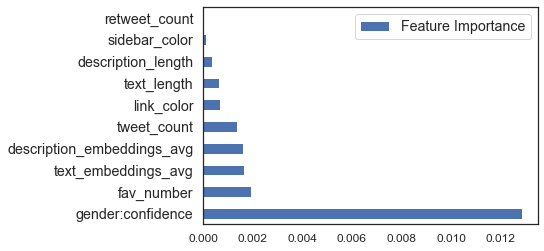

In [1156]:
tweet_importance = tweet_rf_model.feature_importances_
matplotlib.rc('xtick', labelsize = 12)
pd.DataFrame({'Feature Importance':new_importance},
            index=np.append(X_train.columns[:8],['text_embeddings_avg','description_embeddings_avg'])).sort_values(by = 'Feature Importance', ascending=False).plot(kind='barh')

In [1161]:
percentage=dataset_clean['gender'].value_counts(normalize=True)

In [1162]:
random_guess_accuracy=percentage[0]**2+percentage[1]**2+percentage[2]**2+percentage[3]**2
random_guess_accuracy

0.3009394760994105

# Q3 How well do stylistic features to predict gender label?

In [1034]:
X_train_style=X_train[['link_color', 'sidebar_color']] 
X_test_style=X_test[['link_color', 'sidebar_color']] 

In [1035]:
y_train

gender
0      unknown
1         male
2        brand
3        brand
4        brand
...        ...
13962     male
13963     male
13964   female
13965     male
13966    brand

[13967 rows x 1 columns]

In [1036]:
tweet_rf_model_style = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
tweet_rf_model_style.fit(X_train_style,y_train)

y_pred_style = tweet_rf_model_style.predict(X_test_style)
X_test_style['predicted_rf_tree'] = y_pred_style

accuracy_style = accuracy_score(y_test,y_pred_style)
print('Accuracy: {0: .2%}'.format(accuracy_style))

Accuracy:  40.13%


In [1037]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
    
             }
grid_clf = GridSearchCV(tweet_rf_model_style, param_grid, cv=10)
grid_clf.fit(X_train_style,y_train)
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 25}

In [1059]:
X_train_style=X_train[['link_color', 'sidebar_color']] 
X_test_style=X_test[['link_color', 'sidebar_color']] 
tweet_rf_model_style = skens.RandomForestClassifier(max_depth=7,n_estimators=20,oob_score=True, criterion='entropy')
tweet_rf_model_style.fit(X_train_style,y_train)

y_pred_style = tweet_rf_model_style.predict(X_test_style)
X_test_style['predicted_rf_tree_style'] = y_pred_style

accuracy_style = accuracy_score(y_test,y_pred_style)
print('Accuracy: {0: .2%}'.format(accuracy_style))

Accuracy:  41.00%


In [1071]:
def comparePlot(input_frame,real_column,predicted_column):
    df_a = input_frame.copy()
    df_b = input_frame.copy()
    df_a['label_source'] = 'Gender'
    df_b['label_source'] = 'Classifier'
    df_a['label'] = df_a[real_column]
    df_b['label'] = df_b[predicted_column].apply(lambda x: 'Predict %s'%x)
    df_c = pd.concat((df_a, df_b), axis=0, ignore_index=True)
    sns.lmplot(x='link_color', y='sidebar_color', col='label_source',
               hue='label', data=df_c, fit_reg=False, size=4);

In [1072]:
X_test_style['gender']=y_test['gender']

In [1073]:
X_test_style.head()

link_color  sidebar_color predicted_rf_tree_style   gender
0          77            365                   brand    brand
1          77            365                   brand     male
2         364            558                  female   female
3          77            365                   brand  unknown
4          77            365                   brand     male

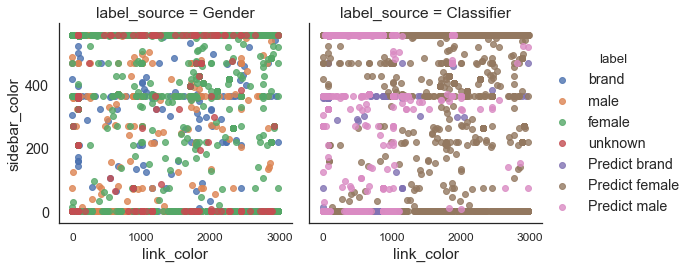

In [1074]:
comparePlot(X_test_style, "gender","predicted_rf_tree_style")

# Q4 How well do text features to predict gender label?

In [1091]:
X_train.columns

Index(['gender:confidence', 'fav_number', 'link_color', 'retweet_count',
       'sidebar_color', 'tweet_count', 'text_length', 'description_length',
       'embedding_text_0', 'embedding_text_1',
       ...
       'embedding_description_290', 'embedding_description_291',
       'embedding_description_292', 'embedding_description_293',
       'embedding_description_294', 'embedding_description_295',
       'embedding_description_296', 'embedding_description_297',
       'embedding_description_298', 'embedding_description_299'],
      dtype='object', length=608)

In [1100]:
X_train_t=X_train.drop(columns=['gender:confidence', 'fav_number','link_color','retweet_count','sidebar_color','tweet_count','text_length','description_length'])
X_test_t=X_test.drop(columns=['gender:confidence', 'fav_number','link_color','retweet_count','sidebar_color','tweet_count','text_length','description_length'])

In [1101]:
X_train_t.shape

(13967, 600)

In [1042]:
X_train_t.shape

(13967, 600)

In [1094]:
tweet_rf_model_t = skens.RandomForestClassifier(max_depth=9,n_estimators=25,oob_score=True, criterion='entropy')
tweet_rf_model_t.fit(X_train_t,y_train)

y_pred_t = tweet_rf_model_t.predict(X_test_t)


accuracy_t = accuracy_score(y_test,y_pred_t)
print('Accuracy: {0: .2%}'.format(accuracy_t))

Accuracy:  57.82%


In [1044]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
    
             }
grid_clf = GridSearchCV(tweet_rf_model_t, param_grid, cv=10)
grid_clf.fit(X_train_t,y_train)
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 25}

In [1075]:
X_train_t.head()

embedding_text_0  embedding_text_1  embedding_text_2  embedding_text_3  \
0         -0.025271          0.241898          0.140981          0.053755   
1         -0.068574          0.119691          0.095145          0.056794   
2          0.029676          0.181318          0.241852         -0.142272   
3         -0.225402          0.659650          0.524246          0.083422   
4         -0.022875          0.190586          0.228905         -0.054171   

   embedding_text_4  embedding_text_5  embedding_text_6  embedding_text_7  \
0         -0.052747         -0.086924          0.003239          0.103604   
1          0.054341         -0.066916         -0.094399          0.117065   
2         -0.121930         -0.109606         -0.071168          0.120496   
3         -0.177454         -0.371426         -0.218702          0.204925   
4         -0.105382         -0.076461         -0.087333          0.131984   

   embedding_text_8  embedding_text_9  ...  embedding_description_290  \
0          0.024776          0.012041  ...                   0.000973   
1          0.179379          0.092672  ...                   0.036550   
2          0.078879          0.008646  ...                  -0.349521   
3          0.334485          0.099938  ...                   0.011658   
4          0.085042          0.116237  ...                  -0.038828   

   embedding_description_291  embedding_description_292  \
0                   0.309356                   0.018388   
1                  -0.032121                  -0.132678   
2                   0.119158                   0.078194   
3                   0.017178                   0.054085   
4                   0.037803                   0.009906   

   embedding_description_293  embedding_description_294  \
0                  -0.168422                  -0.107036   
1                  -0.001762                  -0.020274   
2                   0.044672                  -0.130194   
3                   0.024500                  -0.059696   
4                   0.018067                  -0.031172   

   embedding_description_295  embedding_description_296  \
0                   0.202526                   0.059256   
1                   0.155388                   0.113209   
2                  -0.064297                  -0.141719   
3                  -0.041900                   0.100863   
4                   0.014808                   0.009684   

   embedding_description_297  embedding_description_298  \
0                   0.304882                  -0.108191   
1                   0.101214                  -0.179556   
2                  -0.111813                   0.292369   
3                  -0.001774                  -0.044452   
4                   0.017526                   0.035838   

   embedding_description_299  
0                   0.106264  
1                   0.010038  
2                  -0.258038  
3                  -0.167606  
4                  -0.091598  

[5 rows x 600 columns]

In [1124]:
X_test_t['mean_description'] =X_train_t.apply(lambda x: mean(x[:300]),axis=1)
X_test_t['mean_text'] =X_train_t.apply(lambda x: mean(x[300:600]),axis=1)

In [1121]:
def comparePlot(input_frame,real_column,predicted_column):
    df_a = input_frame.copy()
    df_b = input_frame.copy()
    df_a['label_source'] = 'Gender'
    df_b['label_source'] = 'Classifier'
    df_a['label'] = df_a[real_column]
    df_b['label'] = df_b[predicted_column].apply(lambda x: 'Predict %s'%x)
    df_c = pd.concat((df_a, df_b), axis=0, ignore_index=True)
    sns.lmplot(x='mean_description', y='mean_text', col='label_source',
               hue='label', data=df_c, fit_reg=False, size=4);

In [1122]:
X_test_t['gender']=y_test['gender']
X_test_t['predicted_rf_tree_t'] = y_pred_t

In [1125]:
X_test_t.head()

embedding_text_0  embedding_text_1  embedding_text_2  embedding_text_3  \
0         -0.002571          0.189421          0.228983         -0.037629   
1          0.044706         -0.065468          0.149180         -0.019493   
2          0.059021         -0.153845          0.054258         -0.009363   
3          0.157011          0.044509          0.284079         -0.136477   
4          0.089615          0.003880          0.109709          0.018469   

   embedding_text_4  embedding_text_5  embedding_text_6  embedding_text_7  \
0         -0.096206         -0.071205         -0.080274          0.120468   
1         -0.058049          0.099323         -0.050113          0.182732   
2          0.134205          0.012027         -0.056198          0.095828   
3         -0.006031          0.016077         -0.078323          0.252671   
4         -0.008720          0.048535          0.003681          0.015777   

   embedding_text_8  embedding_text_9  ...  embedding_description_294  \
0          0.074542          0.137413  ...                  -0.048242   
1          0.096708          0.008495  ...                  -0.024254   
2          0.141464          0.056587  ...                   0.105848   
3          0.125630         -0.071406  ...                  -0.037400   
4          0.163891          0.203879  ...                  -0.024581   

   embedding_description_295  embedding_description_296  \
0                   0.004688                  -0.004862   
1                   0.007915                  -0.003235   
2                   0.045161                   0.090908   
3                   0.006843                   0.004990   
4                  -0.010853                   0.014229   

   embedding_description_297  embedding_description_298  \
0                  -0.009694                   0.007433   
1                  -0.005306                   0.023427   
2                   0.394309                   0.051347   
3                   0.008321                   0.026001   
4                   0.006334                   0.010340   

   embedding_description_299   gender  predicted_rf_tree_t  mean_description  \
0                  -0.106293    brand                brand          0.002322   
1                  -0.071635     male               female          0.007870   
2                  -0.230378   female               female         -0.005132   
3                  -0.108348  unknown               female         -0.004323   
4                  -0.086760     male                brand          0.001968   

   mean_text  
0   0.010806  
1   0.009177  
2  -0.013054  
3  -0.001400  
4   0.000916  

[5 rows x 604 columns]

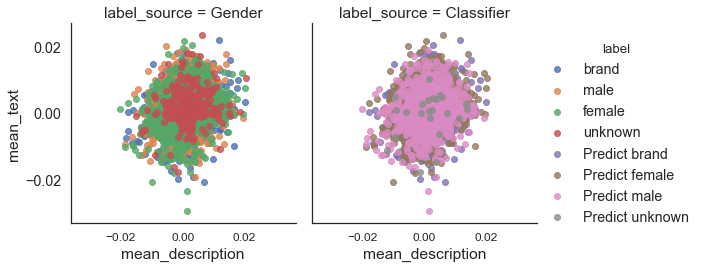

In [1126]:
comparePlot(X_test_t, "gender","predicted_rf_tree_t")